## Processing Sensor Data from Calhoun CZO R1P1
- Marc Berghouse 11/8/2020

This array includes:
- Vaisala CO2 sensor (not sure on model number)
- Apogee O2 sensor (not sure on model number)
- TDR probe for soil moisture and temp

Other data includes:
- PRISM daily precipitation data

Issues:
- CO2 is given in percent, so we might want to figure out how to convert that to ppm

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

def remove_spikes(df, column, window=7, threshold=1):
    """Given a dataframe and column, remove values that are different 
    from the rolling median. For example, with window=5 and threshold=1000 ppm,
    values that are more than 1000 ppm off from the 5-value rolling median will
    be set to NaN.
    
    params: 
        df [dataframe]: dataframe in which the 
        column [str]: name of the column to modify within df
        window [int]: number of records over which to take the median
        threshold [float]: threshold difference above which values are 
            removed (set to NaN)
            
    returns:
        nothing (modifies data in place)
    """
    
    data = df[column].copy()
    
    rollmed = data.rolling(window).median()
    diff = (data - rollmed).abs()
    mask = diff > threshold
    data[mask] = np.nan
    
    df[column] = data

In [2]:
infiles = ["../../raw_data/Calhoun/R1P1/r1p1_gas_SM_ST.csv"]  
# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Calhoun/R1C1_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
columns=['Record', 'Battavg', 'PTemp_C_Avg', 'CO2_50cm.percent', 'T108_C_0cm_Avg',
         'Temp_C_box_Avg','SoilMoisture_50cm.m3m3','BulkEC_50cm.dS/m','T_TDR50cm_Avg','BulkDielectricP_50cm_Avg', 
         'PA_50cm_Avg', 'VR_50cm_Avg', 'ApogeeTemp_50cm.deg.C', 'ApogeeTemp_150cm.deg.C', 
         'BattV_Std', 'PTemp_C_Std','CO2_50cm_std.ppm', 'T108_C_0cm_std','Temp_C_box_std',
         'SoilMoisture_50cm_std.m3m3','BulkEC_50cm_std.dS/m','T_TDR50cm_std','P_50cm_std', 'PA_50cm_std',
         'VR_50cm_std', 'T_O2_50cm_degC_std', 'T_O2_150cm_degC_std', 'O2_50cm.percent.0-100', 'O2_150cm.percent.0-100',
         'CO2_150cm.percent','T_TDR25cm_Std', 'T_TDR25cm_Avg', 'SoilMoisture_25cm.m3m3', 'VWC_25cm_Std', 'BulkEC_25cm.dS/m', 'EC_25cm_Std',
         'P_25cm_Std', 'P_25cm_Avg', 'PA_25cm_Avg', 'PA_25cm_Std', 'VR_25cm_Std', 'VR_25cm_Avg',
         'pct_O2_50cm_Std', 'pct_O2_150cm_Std','CO2_150cm_std.ppm']

# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
ppt = ppt.drop(pd.date_range('2015-07-31', '2016-03-30'), errors='ignore')
#ppt = ppt.drop(pd.date_range('2018-10-02', '2019-06-24'), errors='ignore')
hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

df['elevation']=190
df['latitude']=34.60739

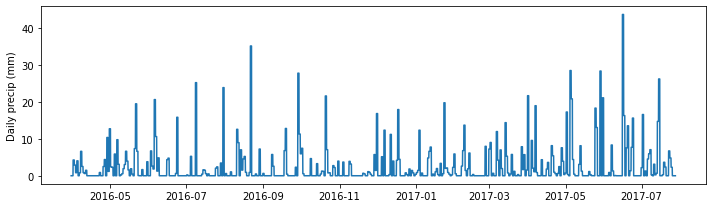

In [4]:
# Plot precip data
df['PRISM_precip.mm']=df['PRISM_precip.mm'].loc[:'2017-09-01']

fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

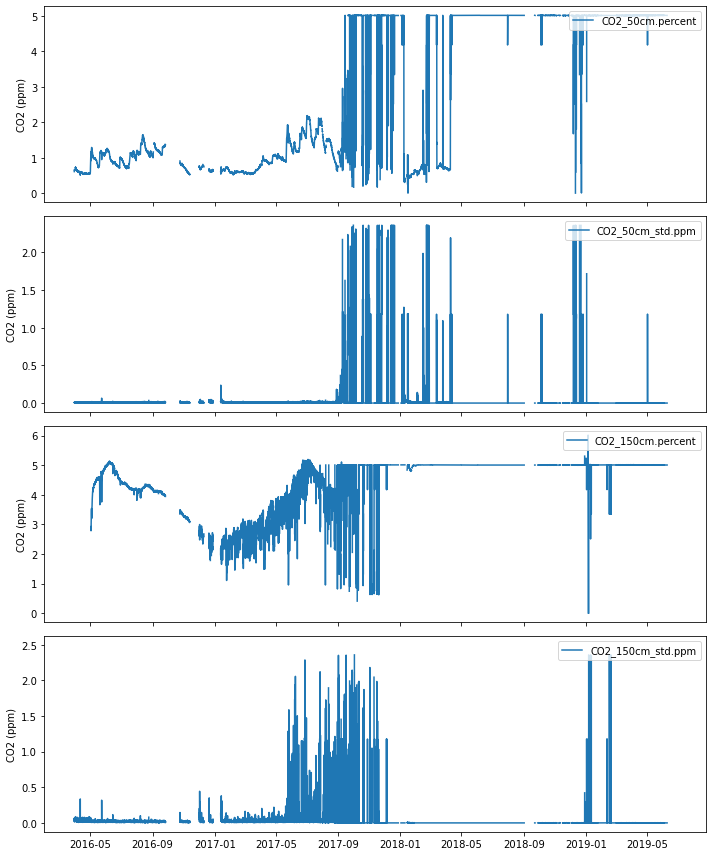

In [5]:
# Plot CO2 data

co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

In [6]:
df['CO2_50cm.percent']=df['CO2_50cm.percent'].loc[:'2017-09-01']
df['CO2_150cm.percent']=df['CO2_150cm.percent'].loc[:'2017-09-01']
df=df.drop(columns='CO2_150cm_std.ppm')
df=df.drop(columns='CO2_50cm_std.ppm')

In [7]:
df['CO2_50cm.ppm']=df['CO2_50cm.percent']*10000
df['CO2_150cm.ppm']=df['CO2_150cm.percent']*10000
df=df.drop(columns='CO2_150cm.percent')
df=df.drop(columns='CO2_50cm.percent')

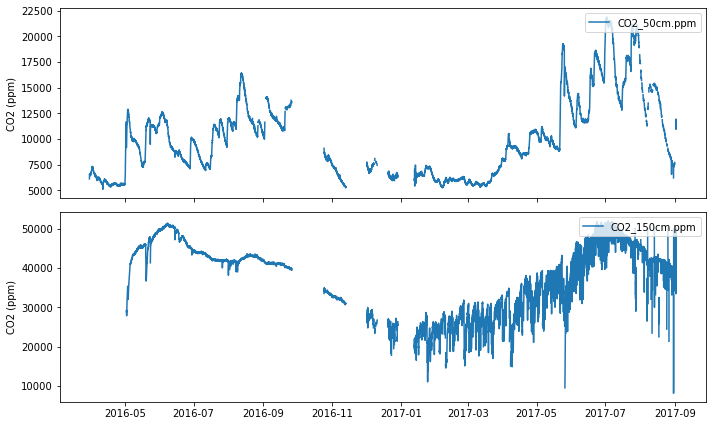

In [8]:
remove_spikes(df, 'CO2_150cm.ppm', window=7, threshold=8000)
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

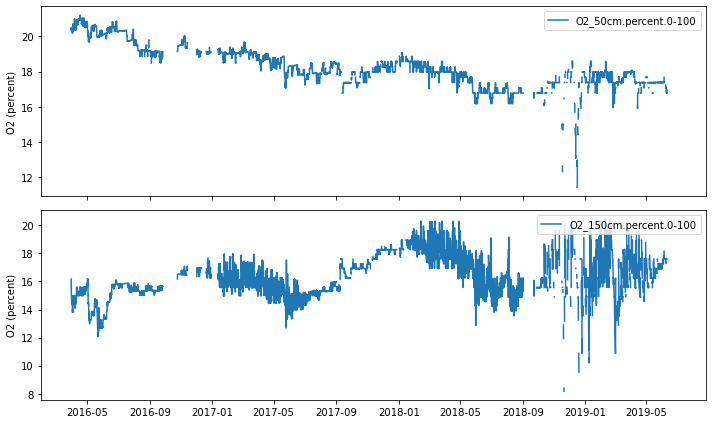

In [9]:
o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

In [10]:
df['O2_50cm.percent.0-100']=df['O2_50cm.percent.0-100'].loc[:'2017-09-01']
df['O2_150cm.percent.0-100']=df['O2_150cm.percent.0-100'].loc[:'2017-09-01']
df=df.drop(columns='pct_O2_150cm_Std')
df=df.drop(columns='pct_O2_50cm_Std')
remove_spikes(df, 'O2_150cm.percent.0-100', window=7, threshold=.8)

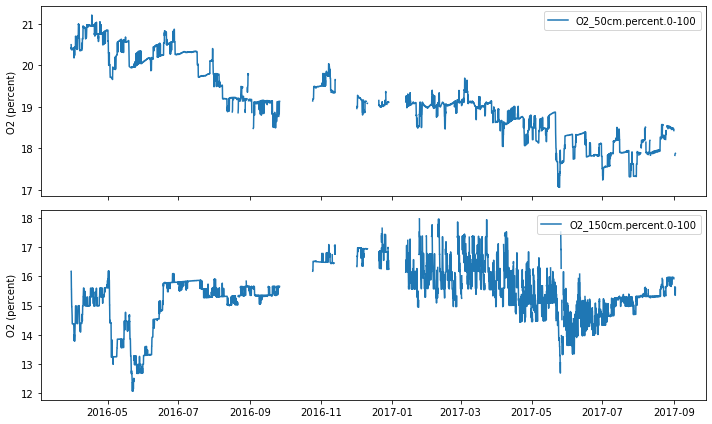

In [11]:
o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

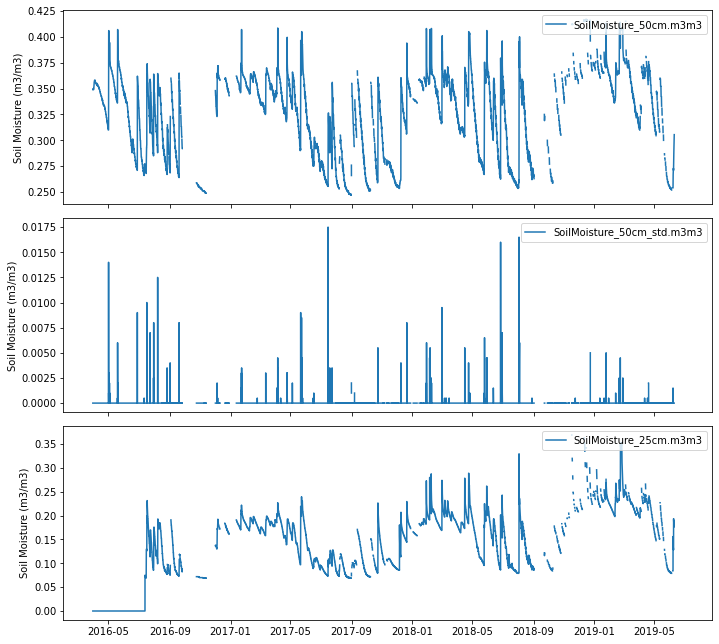

In [12]:
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

In [13]:
df['SoilMoisture_25cm.m3m3']=df['SoilMoisture_25cm.m3m3'].loc[:'2017-09-01']
df['SoilMoisture_50cm.m3m3']=df['SoilMoisture_50cm.m3m3'].loc[:'2017-09-01']
df=df.drop(columns='SoilMoisture_50cm_std.m3m3')
df=df.drop(columns='VWC_25cm_Std')

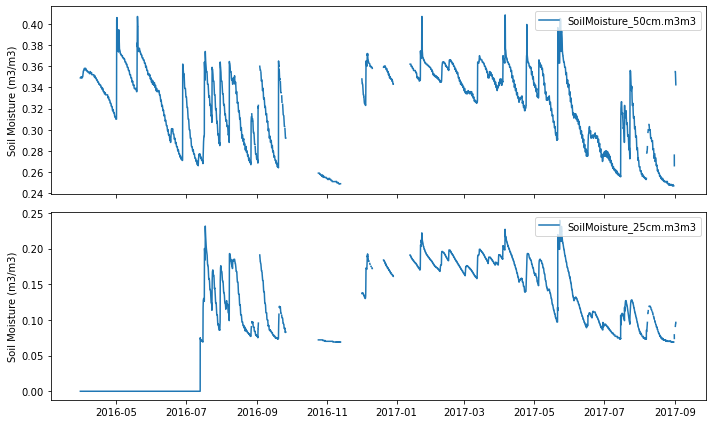

In [14]:
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

In [15]:
df=df.drop(columns='SoilMoisture_25cm.m3m3')


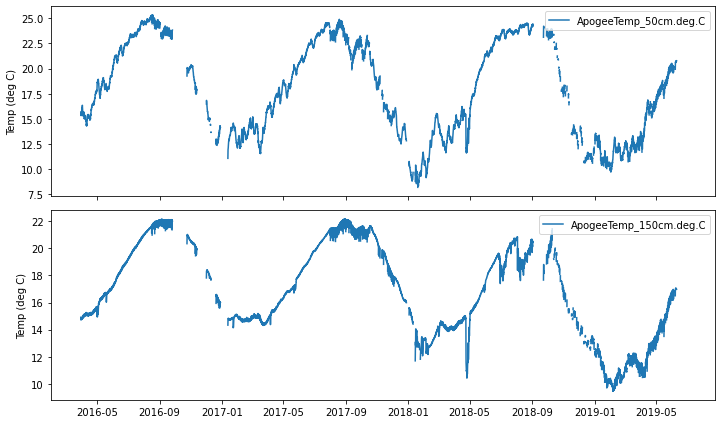

In [16]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

In [17]:
df['ApogeeTemp_50cm.deg.C']=df['ApogeeTemp_50cm.deg.C'].loc[:'2017-09-01']
df['ApogeeTemp_150cm.deg.C']=df['ApogeeTemp_150cm.deg.C'].loc[:'2017-09-01']

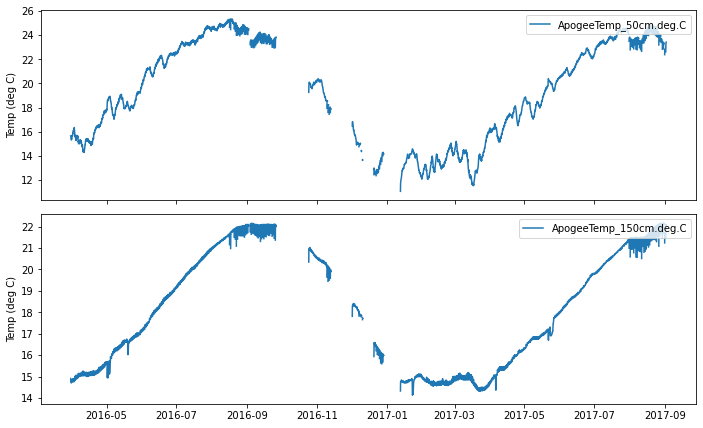

In [18]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

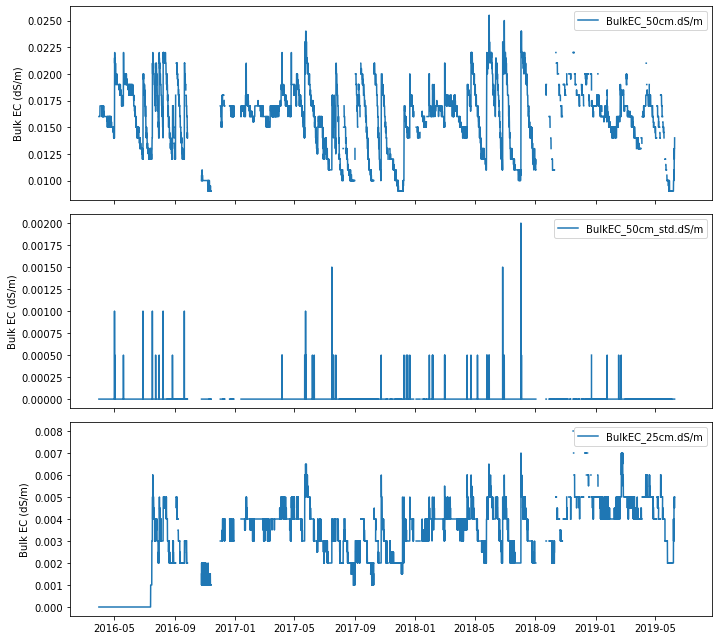

In [19]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

In [20]:

df['BulkEC_25cm.dS/m']=df['BulkEC_25cm.dS/m'].loc[:'2017-09-01']
df['BulkEC_50cm.dS/m']=df['BulkEC_50cm.dS/m'].loc[:'2017-09-01']
df=df.drop(columns='BulkEC_50cm_std.dS/m')
df=df.drop(columns='EC_25cm_Std')

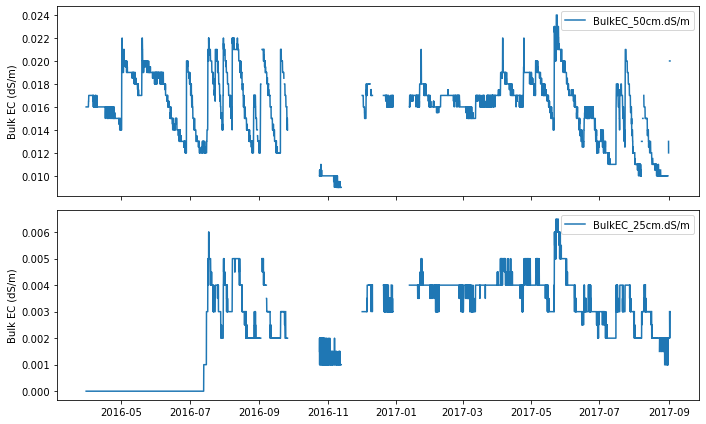

In [21]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

In [22]:
SM_nan_index=df['SoilMoisture_50cm.m3m3'][df['SoilMoisture_50cm.m3m3'].notna()==False]
SM_not_nan_index=df['SoilMoisture_50cm.m3m3'][df['SoilMoisture_50cm.m3m3'].notna()==True]

print (len(SM_nan_index))
print (len(SM_not_nan_index))
print(len(SM_nan_index)/(len(SM_nan_index)+len(SM_not_nan_index)))

mask = df['SoilMoisture_50cm.m3m3'].isna()
d_SM = df.index.to_series()[mask].groupby((~mask).cumsum()[mask]).agg(['first', 'size'])
d_SM.rename(columns=dict(size='num of contig null', first='Start_Date')).reset_index(drop=True)


CO2_nan_index=df['CO2_50cm.ppm'][df['CO2_50cm.ppm'].notna()==False]
CO2_not_nan_index=df['CO2_50cm.ppm'][df['CO2_50cm.ppm'].notna()==True]

print (len(CO2_nan_index))
print (len(CO2_not_nan_index))
print(len(CO2_nan_index)/(len(CO2_nan_index)+len(CO2_not_nan_index)))

mask = df['CO2_50cm.ppm'].isna()
d_CO2 = df.index.to_series()[mask].groupby((~mask).cumsum()[mask]).agg(['first', 'size'])
d_CO2.rename(columns=dict(size='num of contig null', first='Start_Date')).reset_index(drop=True)

print (np.mean(d_CO2['size']))
print (np.std(d_CO2['size']))

18344
10048
0.6460974922513384
18344
10048
0.6460974922513384
199.3913043478261
1649.3101651278182


In [23]:
df=df.drop(columns='BulkEC_25cm.dS/m')
df=df.drop(columns='Record')
df=df.drop(columns='Battavg')
df=df.drop(columns='PTemp_C_Avg')
df=df.drop(columns='T108_C_0cm_Avg')
df=df.drop(columns='Temp_C_box_Avg')
df=df.drop(columns='T_TDR50cm_Avg')
df=df.drop(columns='BulkDielectricP_50cm_Avg')
df=df.drop(columns='PA_50cm_Avg')
df=df.drop(columns='VR_50cm_Avg')
df=df.drop(columns='BattV_Std')
df=df.drop(columns='PTemp_C_Std')
df=df.drop(columns='T108_C_0cm_std')
df=df.drop(columns='T_TDR50cm_std')
df=df.drop(columns='P_50cm_std')
df=df.drop(columns='VR_50cm_std')
df=df.drop(columns='T_O2_50cm_degC_std')
df=df.drop(columns='T_O2_150cm_degC_std')
df=df.drop(columns='T_TDR25cm_Std')
df=df.drop(columns='T_TDR25cm_Avg')
df=df.drop(columns='P_25cm_Std')
df=df.drop(columns='P_25cm_Avg')
df=df.drop(columns='PA_25cm_Avg')
df=df.drop(columns='PA_25cm_Std')
df=df.drop(columns='VR_25cm_Std')
df=df.drop(columns='VR_25cm_Avg')
df=df.drop(columns='Temp_C_box_std')
df=df.drop(columns='PA_50cm_std')


In [24]:
output=df.copy()
outfile = '../../processed_data/Calhoun/R1P1_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.EST')

In [25]:
output

,SoilMoisture_50cm.m3m3,BulkEC_50cm.dS/m,ApogeeTemp_50cm.deg.C,ApogeeTemp_150cm.deg.C,O2_50cm.percent.0-100,O2_150cm.percent.0-100,PRISM_precip.mm,elevation,latitude,CO2_50cm.ppm,CO2_150cm.ppm
TIMESTAMP,,,,,,,,,,,
2016-03-30 17:00:00,0.349,0.016,15.66,14.910,20.501085,16.174612,NaN,190,34.60739,6110.0,NaN
2016-03-30 18:00:00,0.349,0.016,15.65,14.870,20.423321,16.172366,NaN,190,34.60739,6280.0,NaN
2016-03-30 19:00:00,0.349,0.016,15.60,14.845,20.419785,15.894345,NaN,190,34.60739,6375.0,NaN
2016-03-30 20:00:00,0.349,0.016,15.55,14.795,20.392040,15.571107,NaN,190,34.60739,6425.0,NaN
2016-03-30 21:00:00,0.349,0.016,15.52,14.760,20.414129,15.569214,NaN,190,34.60739,6580.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190,34.60739,NaN,NaN
2019-06-26 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190,34.60739,NaN,NaN
2019-06-26 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190,34.60739,NaN,NaN
